In [1]:
import numpy as np
import libpysal as ps 
from mgwr.gwr import GWR, MGWR
from mgwr.sel_bw import Sel_BW
import geopandas as gp
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd

C:\ProgramData\Anaconda3\lib\site-packages\libpysal\io\iohandlers\__init__.py:25: UserWarning: SQLAlchemy and Geomet not installed, database I/O disabled
  warnings.warn('SQLAlchemy and Geomet not installed, database I/O disabled')


In [2]:
#Utility functions for viz of continuous variables
#from splot.utils import shift_colormap, truncate_colormap


#Utility function #1 - forces diverging colormap to be centered at zero
def shift_colormap(cmap, start=0, midpoint=0.5, stop=1.0, name='shiftedcmap'):
    '''
    Function to offset the "center" of a colormap. Useful for
    data with a negative min and positive max and you want the
    middle of the colormap's dynamic range to be at zero

    Parameters
    -----
      cmap : The matplotlib colormap to be altered
      start : Offset from lowest point in the colormap's range.
          Defaults to 0.0 (no lower ofset). Should be between
          0.0 and `midpoint`.
      midpoint : The new center of the colormap. Defaults to 
          0.5 (no shift). Should be between 0.0 and 1.0. In
          general, this should be  1 - vmax/(vmax + abs(vmin))
          For example if your data range from -15.0 to +5.0 and
          you want the center of the colormap at 0.0, `midpoint`
          should be set to  1 - 5/(5 + 15)) or 0.75
      stop : Offset from highets point in the colormap's range.
          Defaults to 1.0 (no upper ofset). Should be between
          `midpoint` and 1.0.
    
    Returns
    -------
    new_cmap : A new colormap that has been shifted. 
    '''
    
    cdict = {
        'red': [],
        'green': [],
        'blue': [],
        'alpha': []
    }

    # regular index to compute the colors
    reg_index = np.linspace(start, stop, 257)

    # shifted index to match the data
    shift_index = np.hstack([
        np.linspace(0.0, midpoint, 128, endpoint=False), 
        np.linspace(midpoint, 1.0, 129, endpoint=True)
    ])

    for ri, si in zip(reg_index, shift_index):
        r, g, b, a = cmap(ri)

        cdict['red'].append((si, r, r))
        cdict['green'].append((si, g, g))
        cdict['blue'].append((si, b, b))
        cdict['alpha'].append((si, a, a))

    new_cmap = mpl.colors.LinearSegmentedColormap(name, cdict)
    plt.register_cmap(cmap=new_cmap)

    return new_cmap

#Utility #2 - truncate colorcap in order to grab only positive or negative portion
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    '''
    Function to truncate a colormap by selecting a subset of the original colormap's values

    Input
    -----
      cmap : Mmatplotlib colormap to be altered
      minval : Minimum value of the original colormap to include in the truncated colormap
      maxval : Maximum value of the original colormap to include in the truncated colormap
      n : Number of intervals between the min and max values for the gradient of the truncated colormap
          
    Returns
    -------
    new_cmap : A new colormap that has been shifted. 
    '''
    new_cmap = mpl.colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

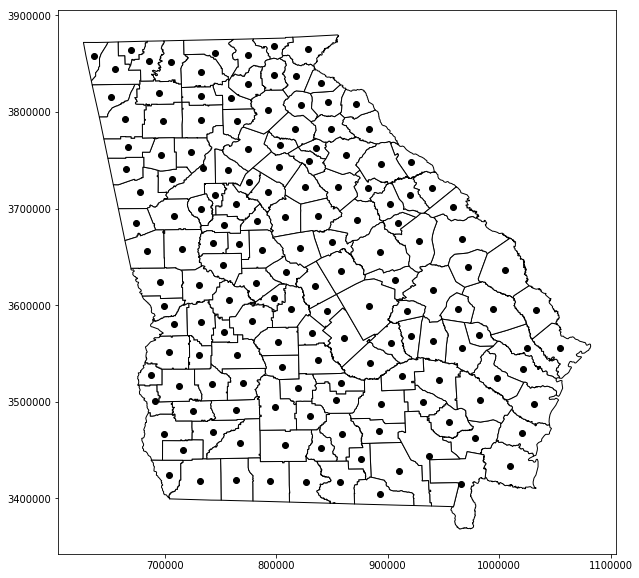

In [3]:
#Load Georgia dataset and generate plot of Georgia counties (figure 1)
georgia_data = pd.read_csv(ps.examples.get_path('GData_utm.csv'))
georgia_shp = gp.read_file(ps.examples.get_path('G_utm.shp'))
fig, ax = plt.subplots(figsize=(10,10))
georgia_shp.plot(ax=ax, **{'edgecolor':'black', 'facecolor':'white'})
georgia_shp.centroid.plot(ax=ax, c='black')

In [4]:
#Prepare Georgia dataset inputs
g_y = georgia_data['PctBach'].values.reshape((-1,1))
g_X = georgia_data[['PctFB', 'PctBlack', 'PctRural']].values
u = georgia_data['X']
v = georgia_data['Y']
g_coords = list(zip(u,v))

g_X = (g_X - g_X.mean(axis=0)) / g_X.std(axis=0)

g_y = g_y.reshape((-1,1))

g_y = (g_y - g_y.mean(axis=0)) / g_y.std(axis=0)

In [5]:
#Calibrate GWR model

gwr_selector = Sel_BW(g_coords, g_y, g_X)
gwr_bw = gwr_selector.search(bw_min=2)
print(gwr_bw)
gwr_results = GWR(g_coords, g_y, g_X, gwr_bw).fit()

117.0


In [6]:
#Calibrate MGWR model

mgwr_selector = Sel_BW(g_coords, g_y, g_X, multi=True)
mgwr_bw = mgwr_selector.search(multi_bw_min=[2])
print(mgwr_bw)
mgwr_results = MGWR(g_coords, g_y, g_X, mgwr_selector).fit()

[92.0, 101.0, 136.0, 158.0]


In [7]:
#Prepare GWR results for mapping

#Add GWR parameters to GeoDataframe
georgia_shp['gwr_intercept'] = gwr_results.params[:,0]
georgia_shp['gwr_fb'] = gwr_results.params[:,1]
georgia_shp['gwr_aa'] = gwr_results.params[:,2]
georgia_shp['gwr_rural'] = gwr_results.params[:,3]

#Obtain t-vals filtered based on multiple testing correction
gwr_filtered_t = gwr_results.filter_tvals()

In [8]:
#Prepare MGWR results for mapping

#Add MGWR parameters to GeoDataframe
georgia_shp['mgwr_intercept'] = mgwr_results.params[:,0]
georgia_shp['mgwr_fb'] = mgwr_results.params[:,1]
georgia_shp['mgwr_aa'] = mgwr_results.params[:,2]
georgia_shp['mgwr_rural'] = mgwr_results.params[:,3]

#Obtain t-vals filtered based on multiple testing correction
mgwr_filtered_t = mgwr_results.filter_tvals()

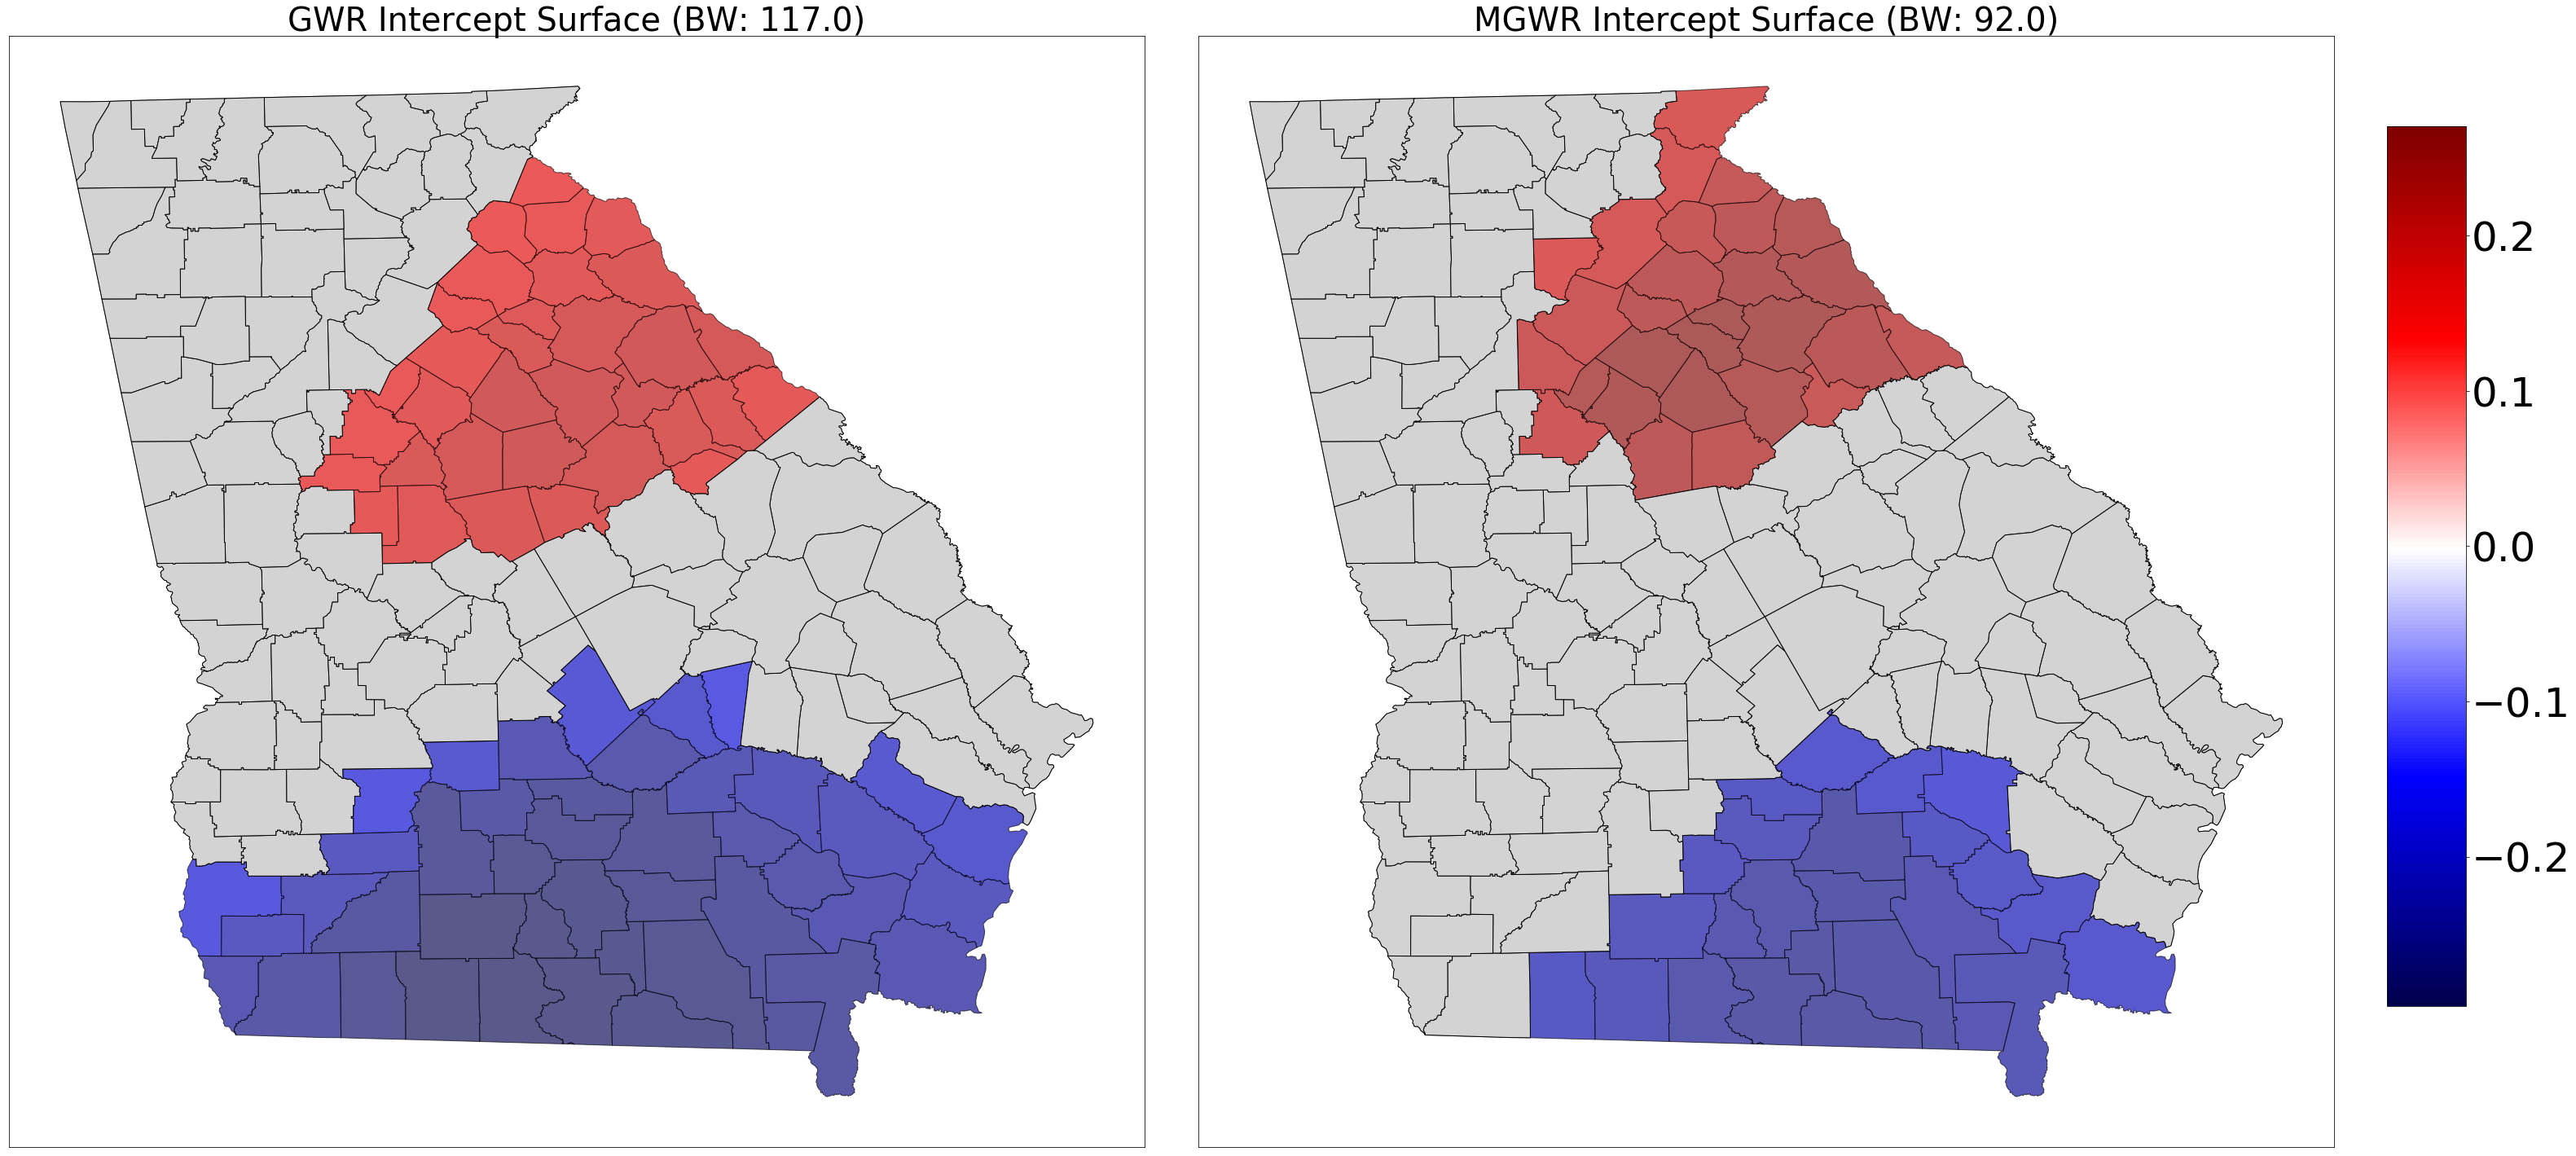

In [9]:
#Comparison maps of GWR vs. MGWR parameter surfaces where the grey units pertain to statistically insignificant parameters

#Prep plot and add axes
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(45,20))
ax0 = axes[0]
ax0.set_title('GWR Intercept Surface (BW: ' + str(gwr_bw) +')', fontsize=40)
ax1 = axes[1]
ax1.set_title('MGWR Intercept Surface (BW: ' + str(mgwr_bw[0]) +')', fontsize=40)

#Set color map
cmap = plt.cm.seismic

#Find min and max values of the two combined datasets
gwr_min = georgia_shp['gwr_intercept'].min()
gwr_max = georgia_shp['gwr_intercept'].max()
mgwr_min = georgia_shp['mgwr_intercept'].min()
mgwr_max = georgia_shp['mgwr_intercept'].max()
vmin = np.min([gwr_min, mgwr_min])
vmax = np.max([gwr_max, mgwr_max])

#If all values are negative use the negative half of the colormap
if (vmin < 0) & (vmax < 0):
    cmap = truncate_colormap(cmap, 0.0, 0.5)
#If all values are positive use the positive half of the colormap
elif (vmin > 0) & (vmax > 0):
    cmap = truncate_colormap(cmap, 0.5, 1.0)
#Otherwise, there are positive and negative values so the colormap so zero is the midpoint
else:
    cmap = shift_colormap(cmap, start=0.0, midpoint=1 - vmax/(vmax + abs(vmin)), stop=1.)

#Create scalar mappable for colorbar and stretch colormap across range of data values
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))

#Plot GWR parameters
georgia_shp.plot('gwr_intercept', cmap=sm.cmap, ax=ax0, vmin=vmin, vmax=vmax, **{'edgecolor':'black', 'alpha':.65})
#If there are insignificnt parameters plot gray polygons over them
if (gwr_filtered_t[:,0] == 0).any():
    georgia_shp[gwr_filtered_t[:,0] == 0].plot(color='lightgrey', ax=ax0, **{'edgecolor':'black'})

#Plot MGWR parameters
georgia_shp.plot('mgwr_intercept', cmap=sm.cmap, ax=ax1, vmin=vmin, vmax=vmax, **{'edgecolor':'black', 'alpha':.65})
#If there are insignificnt parameters plot gray polygons over them
if (mgwr_filtered_t[:,0] == 0).any():
    georgia_shp[mgwr_filtered_t[:,0] == 0].plot(color='lightgrey', ax=ax1, **{'edgecolor':'black'})
 
#Set figure options and plot 
fig.tight_layout()    
fig.subplots_adjust(right=0.9)
cax = fig.add_axes([0.92, 0.14, 0.03, 0.75])
sm._A = []
cbar = fig.colorbar(sm, cax=cax)
cbar.ax.tick_params(labelsize=50) 
ax0.get_xaxis().set_visible(False)
ax0.get_yaxis().set_visible(False)
ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)
plt.show()

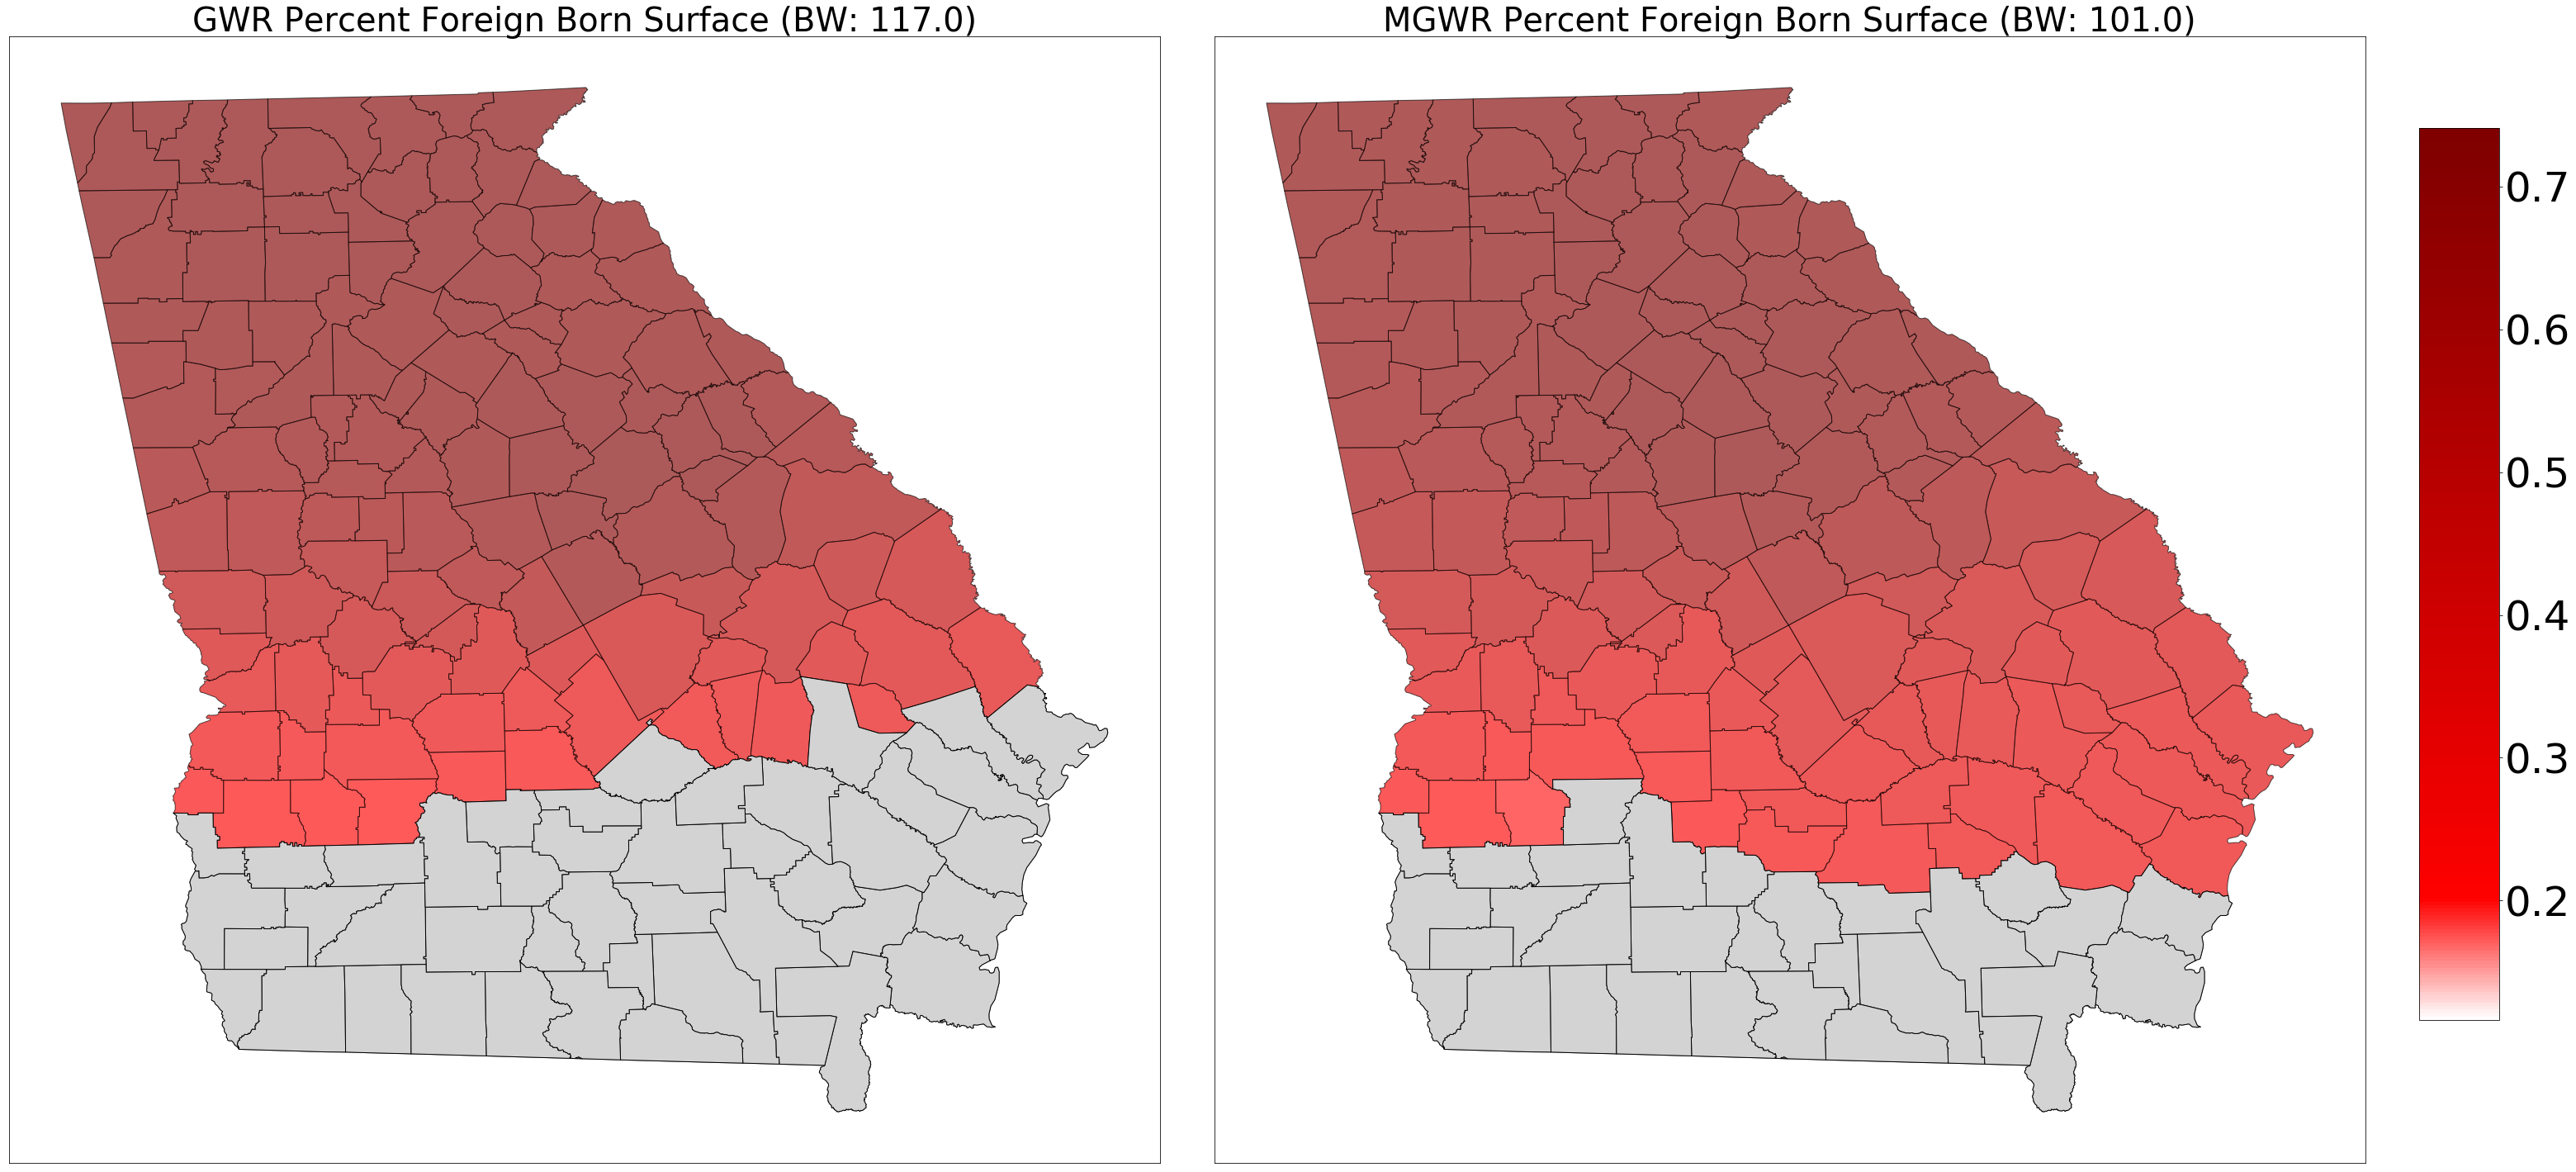

In [10]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(45,20))
ax0 = axes[0]
ax0.set_title('GWR Percent Foreign Born Surface (BW: ' + str(gwr_bw) +')', fontsize=40)
ax1 = axes[1]
ax1.set_title('MGWR Percent Foreign Born Surface (BW: ' + str(mgwr_bw[1]) +')', fontsize=40)
cmap = plt.cm.seismic
gwr_min = georgia_shp['gwr_fb'].min()
gwr_max = georgia_shp['gwr_fb'].max()
mgwr_min = georgia_shp['mgwr_fb'].min()
mgwr_max = georgia_shp['mgwr_fb'].max()
vmin = np.min([gwr_min, mgwr_min])
vmax = np.max([gwr_max, mgwr_max])

if (vmin < 0) & (vmax < 0):
    cmap = truncate_colormap(cmap, 0.0, 0.5)
elif (vmin > 0) & (vmax > 0):
    cmap = truncate_colormap(cmap, 0.5, 1.0)

cmap = shift_colormap(cmap, start=0.0, midpoint=1 - vmax/(vmax + abs(vmin)), stop=1.)
    
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))

georgia_shp.plot('gwr_fb', cmap=sm.cmap, ax=ax0, vmin=vmin, vmax=vmax, **{'edgecolor':'black', 'alpha':.65})
if (gwr_filtered_t[:,1] == 0).any():
    georgia_shp[gwr_filtered_t[:,1] == 0].plot(color='lightgrey', ax=ax0, **{'edgecolor':'black'})

georgia_shp.plot('mgwr_fb', cmap=sm.cmap, ax=ax1, vmin=vmin, vmax=vmax, **{'edgecolor':'black', 'alpha':.65})
if (mgwr_filtered_t[:,1] == 0).any():
    georgia_shp[mgwr_filtered_t[:,1] == 0].plot(color='lightgrey', ax=ax1, **{'edgecolor':'black'})
    
fig.tight_layout()    
fig.subplots_adjust(right=0.9)
cax = fig.add_axes([0.92, 0.14, 0.03, 0.75])
sm._A = []
cbar = fig.colorbar(sm, cax=cax)
cbar.ax.tick_params(labelsize=50) 
ax0.get_xaxis().set_visible(False)
ax0.get_yaxis().set_visible(False)
ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)
plt.show()

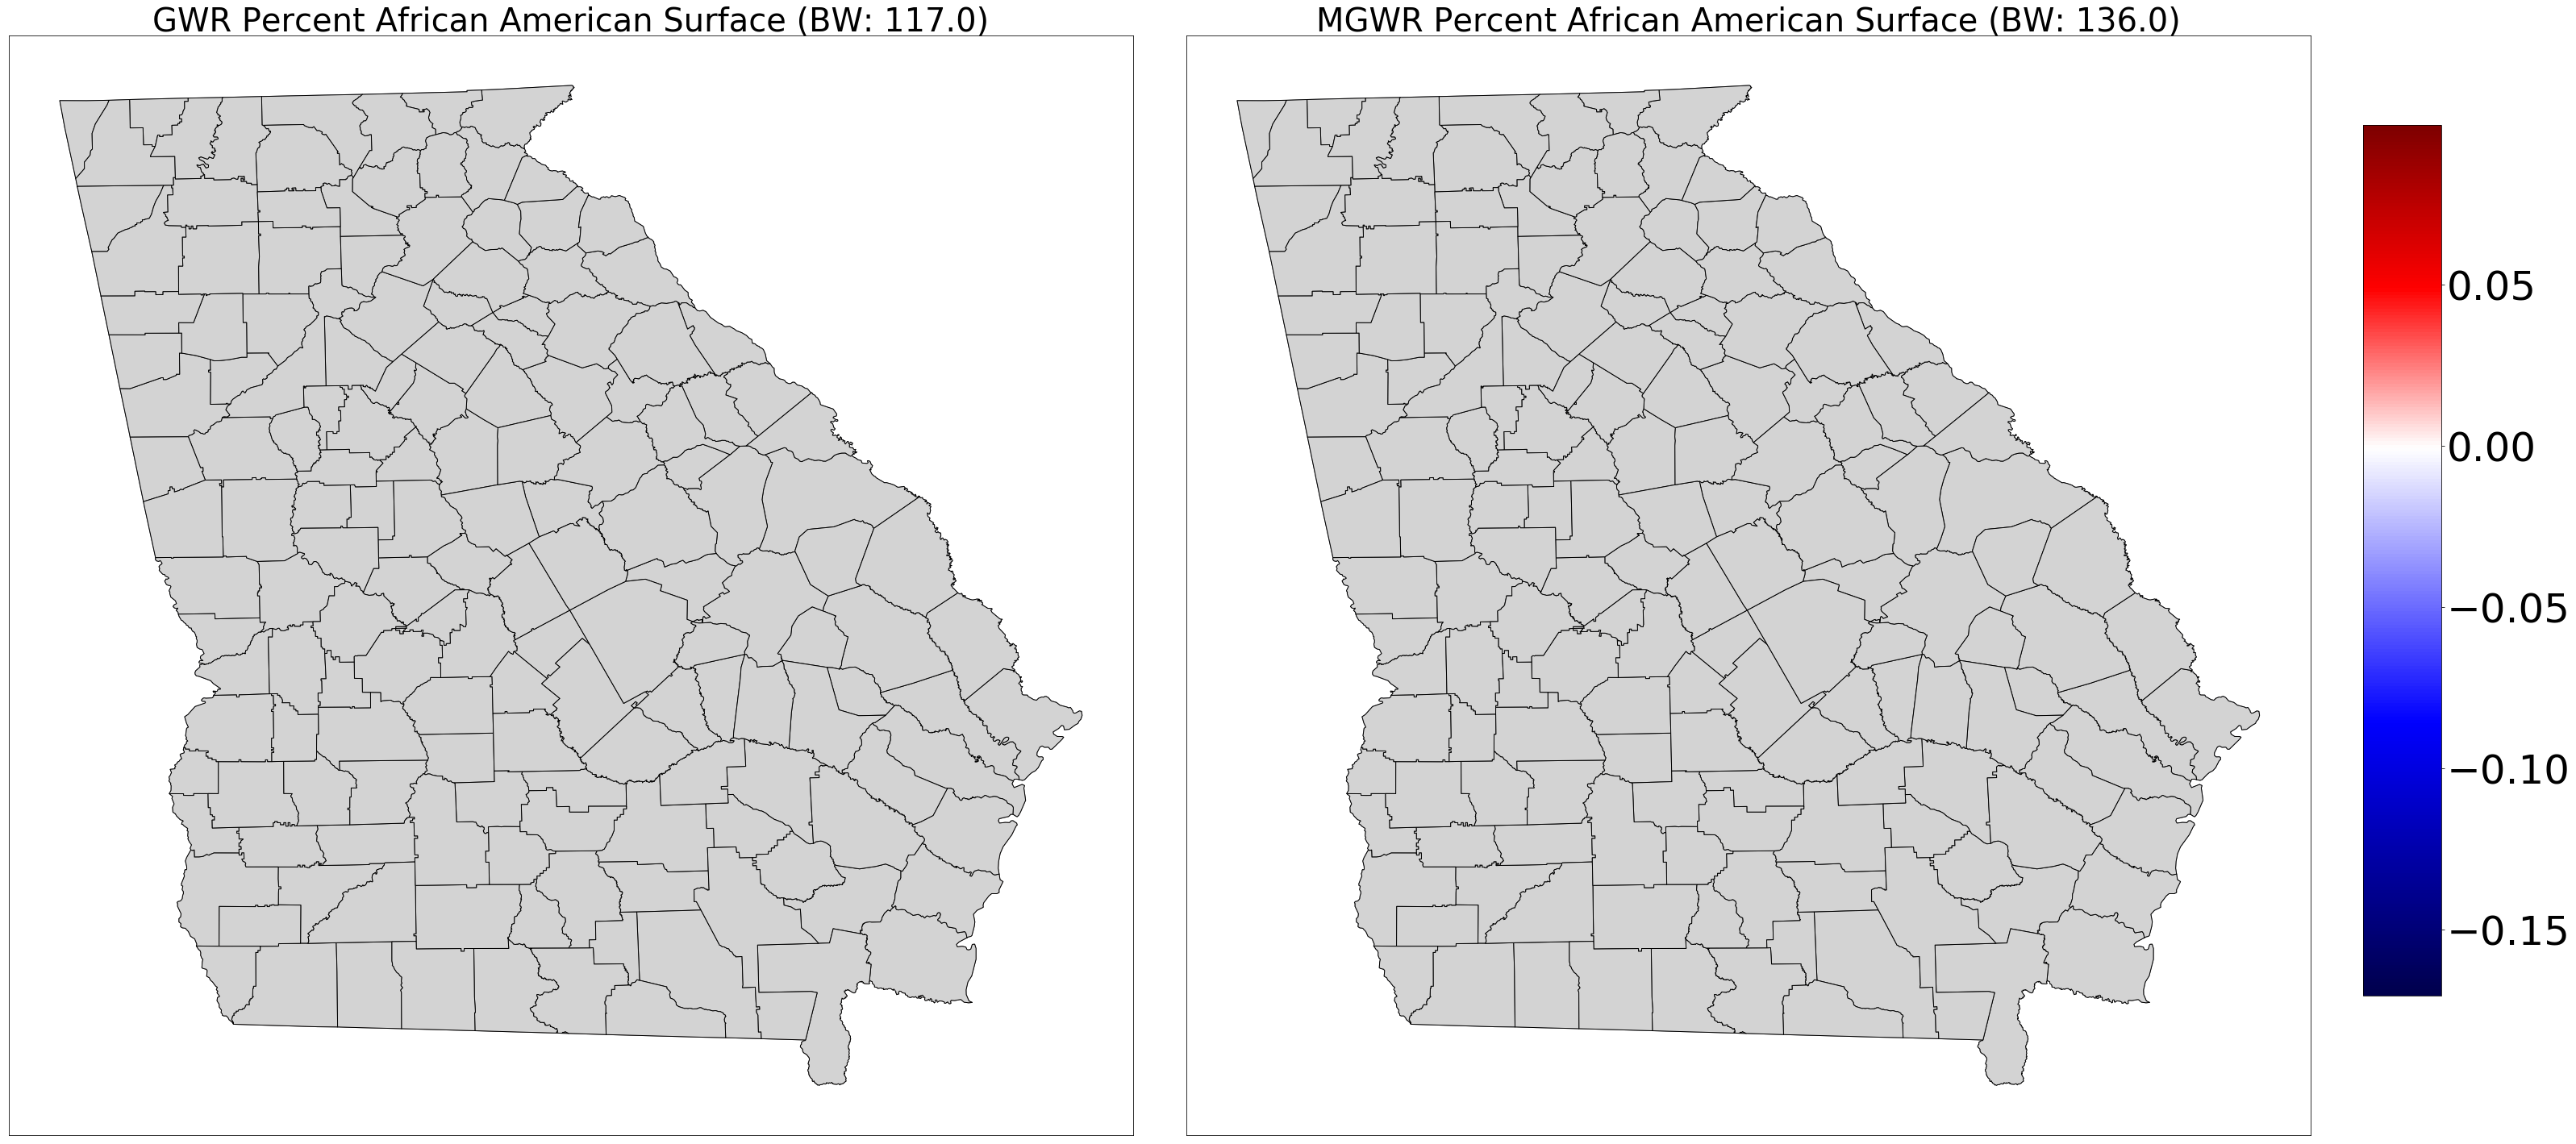

In [11]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(45,20))
ax0 = axes[0]
ax0.set_title('GWR Percent African American Surface (BW: ' + str(gwr_bw) +')', fontsize=40)
ax1 = axes[1]
ax1.set_title('MGWR Percent African American Surface (BW: ' + str(mgwr_bw[2]) +')', fontsize=40)
cmap = plt.cm.seismic
gwr_min = georgia_shp['gwr_aa'].min()
gwr_max = georgia_shp['gwr_aa'].max()
mgwr_min = georgia_shp['mgwr_aa'].min()
mgwr_max = georgia_shp['mgwr_aa'].max()
vmin = np.min([gwr_min, mgwr_min])
vmax = np.max([gwr_max, mgwr_max])

if (vmin < 0) & (vmax < 0):
    cmap = truncate_colormap(cmap, 0.0, 0.5)
elif (vmin > 0) & (vmax > 0):
    cmap = truncate_colormap(cmap, 0.5, 1.0)
else:
    cmap = shift_colormap(cmap, start=0.0, midpoint=1 - vmax/(vmax + abs(vmin)), stop=1.)
    
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))

georgia_shp.plot('gwr_aa', cmap=sm.cmap, ax=ax0, vmin=vmin, vmax=vmax, **{'edgecolor':'black', 'alpha':.65})
if (gwr_filtered_t[:,2] == 0).any():
    georgia_shp[gwr_filtered_t[:,2] == 0].plot(color='lightgrey', ax=ax0, **{'edgecolor':'black'})

georgia_shp.plot('mgwr_aa', cmap=sm.cmap, ax=ax1, vmin=vmin, vmax=vmax, **{'edgecolor':'black', 'alpha':.65})
if (mgwr_filtered_t[:,2] == 0).any():
    georgia_shp[mgwr_filtered_t[:,2] == 0].plot(color='lightgrey', ax=ax1, **{'edgecolor':'black'})
    
fig.tight_layout()    
fig.subplots_adjust(right=0.9)
cax = fig.add_axes([0.92, 0.14, 0.03, 0.75])
sm._A = []
cbar = fig.colorbar(sm, cax=cax)
cbar.ax.tick_params(labelsize=50) 
ax0.get_xaxis().set_visible(False)
ax0.get_yaxis().set_visible(False)
ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)
plt.show()

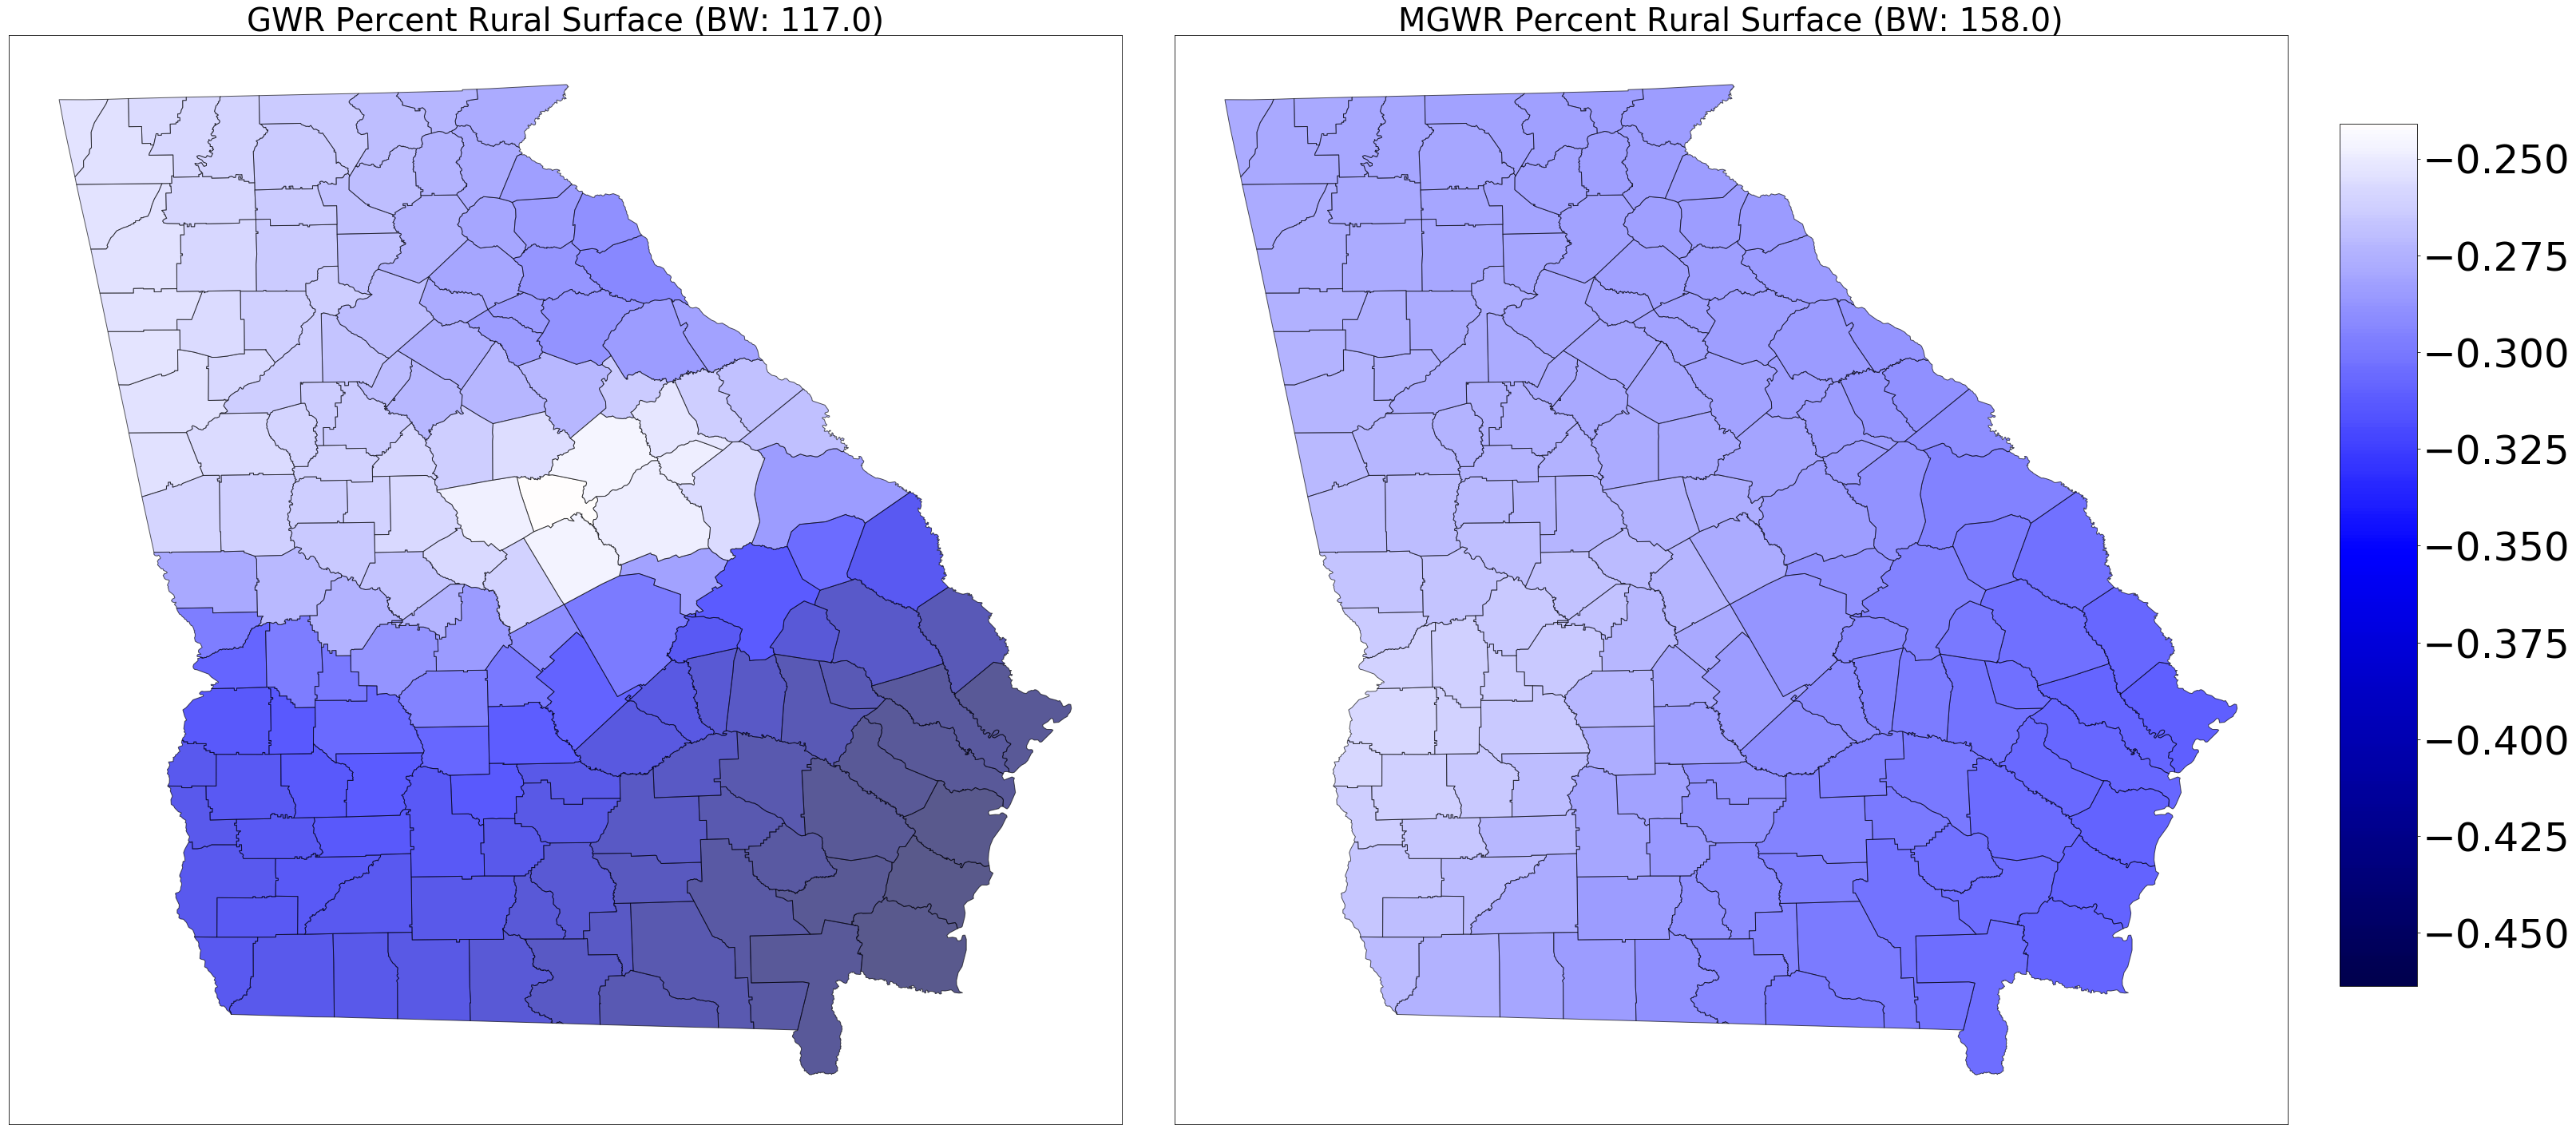

In [12]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(45,20))
ax0 = axes[0]
ax0.set_title('GWR Percent Rural Surface (BW: ' + str(gwr_bw) +')', fontsize=40)
ax1 = axes[1]
ax1.set_title('MGWR Percent Rural Surface (BW: ' + str(mgwr_bw[3]) +')', fontsize=40)
cmap = plt.cm.seismic
gwr_min = georgia_shp['gwr_rural'].min()
gwr_max = georgia_shp['gwr_rural'].max()
mgwr_min = georgia_shp['mgwr_rural'].min()
mgwr_max = georgia_shp['mgwr_rural'].max()
vmin = np.min([gwr_min, mgwr_min])
vmax = np.max([gwr_max, mgwr_max])

if (vmin < 0) & (vmax < 0):
    cmap = truncate_colormap(cmap, 0.0, 0.5)
elif (vmin > 0) & (vmax > 0):
    cmap = truncate_colormap(cmap, 0.5, 1.0)
else:
    cmap = shift_colormap(cmap, start=0.0, midpoint=1 - vmax/(vmax + abs(vmin)), stop=1.)
    
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))

georgia_shp.plot('gwr_rural', cmap=sm.cmap, ax=ax0, vmin=vmin, vmax=vmax, **{'edgecolor':'black', 'alpha':.65})
if (gwr_filtered_t[:,3] == 0).any():
    georgia_shp[gwr_filtered_t[:,3] == 0].plot(color='lightgrey', ax=ax0, **{'edgecolor':'black'})

georgia_shp.plot('mgwr_rural', cmap=sm.cmap, ax=ax1, vmin=vmin, vmax=vmax, **{'edgecolor':'black', 'alpha':.65})
if (mgwr_filtered_t[:,3] == 0).any():
    georgia_shp[mgwr_filtered_t[:,3] == 0].plot(color='lightgrey', ax=ax1, **{'edgecolor':'black'})

fig.tight_layout()    
fig.subplots_adjust(right=0.9)
cax = fig.add_axes([0.92, 0.14, 0.03, 0.75])
sm._A = []
cbar = fig.colorbar(sm, cax=cax)
cbar.ax.tick_params(labelsize=50) 
ax0.get_xaxis().set_visible(False)
ax0.get_yaxis().set_visible(False)
ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)
plt.show()

In [13]:
import pickle as pk
pk.dump(mgwr_results, open('mgwr_example.p', 'wb'), protocol=2)
#Used to produce pickled results for tests